# Liças - Segurando o mundo

### Projeto do 5° semestre da engenharia de computação


#### Professor
- Caio Fernando

#### Alunos
- Pedro Henrique Britto Aragão Andrade
- Thiago Shiguero Kawahara
- Willian Kenzo

# Contextualização

#### Esse projeto tem como intuito o desenvolver um software para a análise de treliças planas, mais específicamente da estrutura da imagem seguinte:

![Estrutura](img/estrutura.png)

# Etapa 1

#### Importação das bibliotecas necessárias e do arquivo em exel com os dados da nossa extrutura

In [119]:
import numpy as np
from funcoesTermosol import importa
from numpy.linalg import det
from matplotlib import pyplot as plt
[nn,N,nm,Inc,nc,F,nr,R] = importa('entrada.xlsx')

# Etapa 2

#### Para uma maior facilidade dos calculos futuramente foi criado um dicionário global que caracteriza cada nó com as suas íncidências

In [120]:
no_indice = {}

for i in range(1, nn + 1):
    no_indice[i] = (2*i-2,2*i-1)

# Etapa 3

#### Para facilitar e deixar o código mais responsível foi necessário criar uma classe elemento, a qual servirá para indicar cada haste da estrutura e suas respectivas carecterísticas como:

- Posição
- Nós iniciais e finais (já foram caracterizados com as suas incidências)
- Comprimento
- Cosseno e seno
- Young's Módulos
- Área
- Matriz de rigidez

In [121]:
class elemento:
    def __init__(self, posicao, no0, nof, E, A):
        self.posicao = posicao
        self.no0 = no_indice[no0]
        self.nof = no_indice[nof]
        self.x0 = N[0][int(no0-1)]
        self.y0 = N[1][int(no0-1)]
        self.xf = N[0][int(nof-1)]
        self.yf = N[1][int(nof-1)]
        self.L = ((self.xf - self.x0)**2 + (self.yf-self.y0)**2)**0.5
        self.sen = (self.yf-self.y0)/self.L
        self.cos = (self.xf-self.x0)/self.L
        self.E = E
        self.A = A
        self.K = E*A/self.L*np.array([[self.cos**2, self.cos*self.sen, -self.cos**2, -self.cos*self.sen],
                                      [self.cos*self.sen, self.sen**2, -self.cos*self.sen, -self.sen**2], 
                                      [-self.cos**2, -self.cos*self.sen, self.cos**2, self.cos*self.sen], 
                                      [-self.cos*self.sen, -self.sen**2, self.cos*self.sen, self.sen**2]])
        self.tensao = 0
        self.deformacao = 0
        self.forca = 0

In [122]:
# Criando os elementos

def criacao_elementos():
    elementos = []  
    for i in range(nm):
        e = elemento(i+1, Inc[i][0], Inc[i][1], Inc[i][2], Inc[i][3])
        elementos.append(e)
    return elementos

elementos = criacao_elementos()

# Etapa 4

#### Com os elementos caracterizados agora podemos criar a matriz de rigidez global do sistema [$K_g$]

![Matriz Global](img/matrizglobal.png)

In [123]:
# Criando um dicionário com as posições dos elementos na matriz global

def matriz_para_dicio(elementos):
    for element in elementos:
        a = element.no0[0], element.no0[1], element.nof[0], element.nof[1]
        k_indice = {}
        for i, j in zip(element.K, a):
            for c, b in zip(i, a):
                k_indice[(j, b)] = c
        element.dicio = k_indice

matriz_para_dicio(elementos)

# Exemplo de como acessar os valores da matriz de rigidez de um elemento
elementos[0].dicio

{(0, 0): 5038531.973700276,
 (0, 1): 2519265.986850138,
 (0, 2): -5038531.973700276,
 (0, 3): -2519265.986850138,
 (1, 0): 2519265.986850138,
 (1, 1): 1259632.993425069,
 (1, 2): -2519265.986850138,
 (1, 3): -1259632.993425069,
 (2, 0): -5038531.973700276,
 (2, 1): -2519265.986850138,
 (2, 2): 5038531.973700276,
 (2, 3): 2519265.986850138,
 (3, 0): -2519265.986850138,
 (3, 1): -1259632.993425069,
 (3, 2): 2519265.986850138,
 (3, 3): 1259632.993425069}

In [124]:
# Matriz global de rigidez do sistema, por enquanto sem considerar
# as condições de contorno, ou seja, sem considerar as forças externas
# e os deslocamentos conhecidos dos nós do sistema

def calcula_Kg(elementos):
    tam = no_indice[nn][1] + 1
    Kg = np.zeros((tam,tam))
    
    for element in elementos:
        for i in range(tam):
            for j in range(tam):
                indice = (i,j)
                if indice in element.dicio:
                    Kg[i][j] += element.dicio[indice]
    return Kg

kg = calcula_Kg(elementos)

# Etapa 5

#### Criação do vetor global das forças concentradas

In [125]:
# Matriz de forças externas do sistema (sem considerar as condições de contorno)
# A matriz de forças externas é uma matriz coluna, onde cada linha representa
# uma força externa aplicada em um nó do sistema (nó 1, nó 2, ..., nó nn)

def calcula_Pg_total():
    Pg = []
    for i in range(len(F)):
        if F[i][0] == 0:
            c = False
            for j in R:
                if i == j[0]:
                    Pg.append("R")
                    c = True
            if c == False:
                Pg.append(0)
        else:
            Pg.append(F[i][0])
    return Pg

Pg_total = calcula_Pg_total()

# Etapa 6

#### Com o vetor global das forças, podemos enfim aplicar os contornos na matriz de rigidez global

In [126]:
# Matriz global de rigidez do sistema, considerando as condições de contorno
# e as forças externas aplicadas nos nós do sistema (nó 1, nó 2, ..., nó nn)
indices = [i for i, j in enumerate(Pg_total) if j == "R"]
def kg_filtrado(kg, Pg_total):
    tam = (no_indice[nn][1] + 1 - len(indices))
    Kg_novo = np.zeros((tam,tam))

    a = 0
    b = 0
    for i, linha in enumerate(kg):
        if i not in indices:
            for j, coluna in enumerate(linha):
                if j not in indices:
                    Kg_novo[a][b] = coluna
                    b += 1
            a += 1
            b = 0
    
    Pg = [i for i in Pg_total if i != "R"]
                
    return Kg_novo, Pg
    
    
kg_fil, Pg_fil = kg_filtrado(kg, Pg_total)

# Etapa 7

#### Com o [$K_g$] e o [$P_g$] filtrados, ou seja, com as condições de contornos aplicadas precisamos resolver um sistema de equações para abter os seus deslocamentos, para chegar em tais resultados existe algumas formas como a utilização da equação de Jacobi, porém para esse sistema foi utilizado a equação de Gauss Seidel

![Equações](img/equa%C3%A7%C3%B5es.png)

In [127]:
# Aplicação da equação de Gauss Seidel para resolver o sistema de equações
# e encontrar os deslocamentos dos nós do sistema

def gauss_seidel(Pg_fil, kg_fil, tol, max_iter):
    x = np.zeros(kg_fil.shape[0])
    
    erros = []
    
    for i in range(max_iter):
        for j in range(kg_fil.shape[0]):
            x[j] = (Pg_fil[j] - np.dot(kg_fil[j, :j], x[:j]) - np.dot(kg_fil[j, j+1:], x[j+1:]))/kg_fil[j, j]
        erro = np.linalg.norm(np.dot(kg_fil, x) - Pg_fil)
        erro = erro/np.linalg.norm(Pg_fil)
        erros.append(erro)
        if erro < tol:
            break
    
    x_expandido = x.copy()
    for i in indices:
        x_expandido = np.insert(x_expandido, i, 0)
    
    return x, np.array(x_expandido), erros
    
x, x_expandido, erros = gauss_seidel(Pg_fil, kg_fil, 1e-6, 1000)

# O código irá devolver os deslocamentos dos nós do sistema na forma
# expandida e na forma reduzida, ou seja, com e sem as condições de contorno
# além disso, o código irá devolver uma lista com os erros de cada iteração
# até que o erro seja menor que a tolerância estabelecida (tol) ou até que
# o número máximo de iterações (max_iter) seja atingido

# Etapa 8

#### Com os deslocamentos calculados podemos, enfim, calcular a deformação, tensão, a força e as reações de apoio da estrutura

In [128]:
# Calculando as reações de apoio do sistema

def calcula_reacoes(x_expandido, kg):
    reacoes = np.dot(kg, x_expandido)
    reacoes = [reacoes[i] for i in indices]
    return np.array(reacoes)

reacoes = calcula_reacoes(x_expandido, kg)

In [129]:
# Calculando a tensão, deformação e força de cada elemento do sistema

def tensão_deformação_forca(elementos, x_expandido):
    for element in elementos:
        _cos = element.cos
        _sen = element.sen
        a = element.no0[0], element.no0[1], element.nof[0], element.nof[1]
        u = np.array([x_expandido[i] for i in a])
        element.tensao = (element.E/element.L)*np.dot(np.array([-_cos, -_sen, _cos, _sen]), u)
        element.deformacao = (1/element.L)*np.dot(np.array([-_cos, -_sen, _cos, _sen]), u)
        element.forca = element.tensao*element.A
    
tensão_deformação_forca(elementos, x_expandido)

# Etapa 9

#### Varificação dos dados obtidos

In [130]:
tensao = np.array([element.tensao for element in elementos])
forca = np.array([element.forca for element in elementos])
deformacao = np.array([element.deformacao for element in elementos])

print("Reacoes de apoio [N]")
print(reacoes)

print("\n")
print("Deslocamentos [m]")
print(x_expandido)

print("\n")
print("Deformacoes []")
print(deformacao)

print("\n")
print("Forcas internas [N]")
print(forca)

print("\n")
print("Tensoes internas [Pa]")
print(tensao)

meuArquivo = open('saida.txt', 'w')
meuArquivo.write(f"Reacoes de apoio [N]\n{(reacoes)}\n")
meuArquivo.write(f"\nDeslocamentos [m]\n{(x_expandido)}\n")
meuArquivo.write(f"\nDeformacoes []\n{(deformacao)}\n")
meuArquivo.write(f"\nForcas internas [N]\n{(forca)}\n")
meuArquivo.write(f"\nTensoes internas [Pa]\n{(tensao)}\n")
meuArquivo.close()

Reacoes de apoio [N]
[3900.00220546 2899.99736372 1599.99706971]


Deslocamentos [m]
[ 0.          0.          0.00100474 -0.00431173  0.00035977 -0.00466312
  0.00025974 -0.00443927  0.00055859 -0.00463758 -0.00032427 -0.00424778
  0.00116451  0.        ]


Deformacoes []
[-0.00639515 -0.00449315 -0.00377645 -0.00352836 -0.00075561  0.00075561
  0.00191125 -0.00191125  0.00187379  0.00103551  0.00315586]


Forcas internas [N]
[-6484.59123986 -4555.9829687  -3829.26043194 -3577.70221166
  -766.17737152   766.1765397   1937.98228402 -1937.98384069
  1899.99252199  1049.99480345  3199.99413941]


Tensoes internas [Pa]
[-1.23516024e+09 -8.67806280e+08 -7.29382939e+08 -6.81467088e+08
 -1.45938547e+08  1.45938389e+08  3.69139483e+08 -3.69139779e+08
  3.61903338e+08  1.99999010e+08  6.09522693e+08]


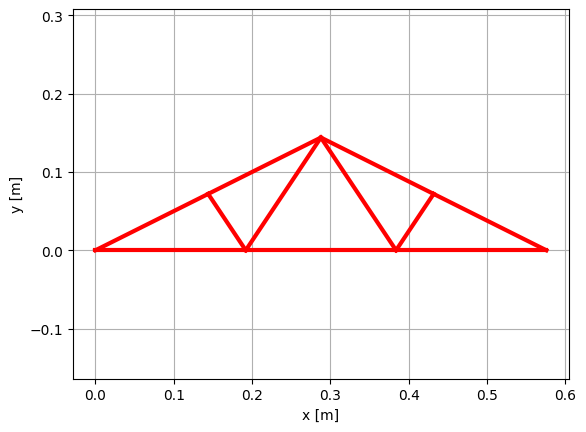

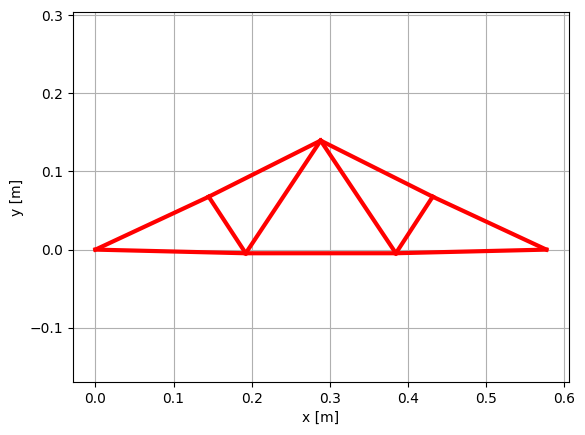

In [131]:
# Plotando o gráfico do sistema antes e depois da aplicação das forças externas

testex = N[0] + x_expandido[::2]
testey = N[1] + x_expandido[1::2]

def plota(N,Inc):
    # Numero de membros
    nm = len(Inc[:,0])
    
    import matplotlib as mpl
    import matplotlib.pyplot as plt

#    plt.show()
    fig = plt.figure()
    # Passa por todos os membros
    for i in range(nm):
        
        # encontra no inicial [n1] e final [n2] 
        n1 = int(Inc[i,0])
        n2 = int(Inc[i,1])        

        plt.plot([N[0,n1-1],N[0,n2-1]],[N[1,n1-1],N[1,n2-1]],color='r',linewidth=3)


    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.grid(True)
    plt.axis('equal')

deforma = [testex, testey]
deforma = np.array(deforma)

plota(N, Inc)

plota(deforma, Inc)

plt.show()